In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## ファイル読み込み

In [2]:
f = open("build/output.dat", "r")

data = f.readlines()

f.close()

## データ読み込み

In [3]:
#何枚目を使うか
page =  888 

In [4]:
#画素数の取得
pixel_info = data[1].split(" ")
ni = int(pixel_info[1])
pixel_info = data[2].split(" ")
nj = int(pixel_info[1])

print("ni= {}".format(ni))
print("nj= {}".format(nj))


ni= 100
nj= 50


In [5]:

#領域の長さの取得
length_info = data[3].split(" ")
Lx = float(length_info[1])
length_info = data[4].split(" ")
Ly = float(length_info[1])


In [6]:
print(Lx)
print(Ly)

8.0
4.0


In [7]:

#角柱領域の取得
mask_info = data[5].split(" ")
prism_left = float(mask_info[1])

mask_info = data[6].split(" ")
prism_right = float(mask_info[1])

mask_info = data[7].split(" ")
prism_under = float(mask_info[1])

mask_info = data[8].split(" ")
prism_above = float(mask_info[1])


In [8]:

#刻み幅
h = Lx/ni

#速度データの読み込み
u_tmp = np.zeros((nj, ni))
v_tmp = np.zeros((nj, ni))
offset_start = 10
offset = offset_start + 2 * nj * page
for j in range(0, nj):
    u_info = data[offset + j].split(" ")
    for i in range(0, ni):
        u_tmp[j][i] = float(u_info[i])
for j in range(0, nj):
    v_info = data[offset + nj + j].split(" ")
    for i in range(0, ni):
        v_tmp[j][i] = float(v_info[i])

##  プロット用にデータ変換

In [9]:
U = np.zeros((nj-1, ni-1))
V = np.zeros((nj-1, ni-1))
X = np.zeros((nj-1, ni-1))
Y = np.zeros((nj-1, ni-1))

In [10]:
# 速度
more_than_6_5_i = 10000000
for j in range(0, nj-1):
    for i in range(0, ni-1):
        U[j][i] = (u_tmp[j][i] + u_tmp[j+1][i]) * 0.5
        V[j][i] = (v_tmp[j+1][i+1] + v_tmp[j+1][i]) * 0.5
        X[j][i] = h * float(i + 1)
        Y[j][i] = h * float(nj - j - 1)

        #x座標が6.5より大きい範囲を探す(more_than_6_5_i = 136になる)
        if X[j][i] > 6.5 and more_than_6_5_i > i:
            more_than_6_5_i = i


In [11]:

# 渦度
Vort = np.zeros((nj-1, ni-1))
for j in range(0, nj-1):
    for i in range(0, ni-1):
        Vort[j][i] = (-v_tmp[j+1][i]+v_tmp[j+1][i+1])/h - (-u_tmp[j+1][i] + u_tmp[j][i])/h

In [12]:
# 物体領域内のindex座標の配列を作り(角柱1個)
# 速度、渦度をinf, 0にする。
# inobject_indices = []
# for j in range(0, nj-1):
#     for i in range(0, ni-1):
#         if (prism_left <= X[j][i] <= prism_right) and (prism_under <= Y[j][i] <= prism_above):
#             U[j][i] = float("+infinity")
#             V[j][i] = float("+infinity")
#             Vort[j][i] = 0.0
#             inobject_indices.append((i, j))

In [13]:
# 物体領域内のindex座標の配列を作り(円1個)
# 速度、渦度をinf, 0にする。
inobject_indices = []
for j in range(0, nj-1):
    for i in range(0, ni-1):
        if (X[j][i] - 3.0)**2.0 + (Y[j][i] - 3.0)**2.0 <= (0.5 + h)**2.0:
            # U[j][i] = float("+infinity")
            # V[j][i] = float("+infinity")
            # Vort[j][i] = 0.0
            inobject_indices.append((i, j))

## プロット

In [14]:
%matplotlib inline

In [15]:
xmin = np.amin(X)
xmax = np.amax(X)
ymin = np.amin(Y)
ymax = np.amax(Y)

In [16]:
# plt.rcParams['figure.figsize'] = (26, 12)

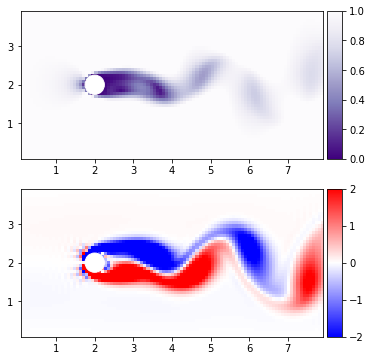

In [17]:

fig, ax = plt.subplots(2, 1, figsize=(12.0, 6.0))

img1 = ax[0].imshow(np.sqrt(U**2.0 + V**2.0),vmin=0.0, vmax=1.0,cmap="Purples_r", extent=(xmin, xmax, ymin, ymax))
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cc0 = plt.Circle((2.0, 2.0), 0.25, fill = True, color="white")
ax[0].add_artist(cc0)
fig.colorbar(img1, cax=cax1)
# ax[0].axis("on")

img2 = ax[1].imshow(Vort,vmin=-2.0, vmax=2.0,cmap="bwr", extent=(xmin, xmax, ymin, ymax))
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cc1 = plt.Circle((2.0, 2.0), 0.25, fill = True, color="white")
ax[1].add_artist(cc1)
fig.colorbar(img2, cax=cax2)
# ax[1].axis("on")

plt.show()

## 指数計算

In [18]:
print(more_than_6_5_i)

U_65 = U[ : , more_than_6_5_i : ]
V_65 = V[ : , more_than_6_5_i : ]
print(np.shape(U_65))

81
(49, 18)


In [19]:
# return [0, 2π]
def atan2(y, x):
    phi = np.arctan2(y, x)
    if phi < 0.0:
        phi = 2.0 * np.pi + phi
    return phi

def get_delta(phi_pre, phi_next):
    # argu = np.arccos(np.cos(phi_pre) * np.cos(phi_next) + np.sin(phi_pre) * np.sin(phi_next))
    argu = np.min([abs(phi_pre - phi_next), 2.0 * np.pi - abs(phi_pre - phi_next)])
    d1 = np.abs(np.mod(phi_pre + argu, 2.0 * np.pi) - phi_next)
    d2 = np.abs(np.mod(phi_pre - argu, 2.0 * np.pi) - phi_next)
    if d1 < d2:
        return argu
    return -argu

In [20]:
#nxnのセル塊で指数計算
n = 1
num_point = 4 * n
index_list = []
index_i = []
index_j = []
phi_list = [0]*num_point
delta_list = [0]*num_point
for j in range(0, np.shape(U)[0]-n, n):
    for i in range(0, np.shape(U)[1]-n, n):
        # if (i,j) in inobject_indices:
        #     continue
        for k in range(n):
            phi_list[k] = atan2(V[j + k][i], U[j + k][i])
        for k in range(n):
            phi_list[n + k] = atan2(V[j + n][i + k], U[j + n][i + k])
        for k in range(n):
            phi_list[2 * n + k] = atan2(V[j + n - k][i + n], U[j + n - k][i + n])
        for k in range(n):
            phi_list[3 * n + k] = atan2(V[j][i + n - k], U[j][i + n - k])
        
        for k in range(num_point-1):
            delta_list[k] = get_delta(phi_list[k], phi_list[k+1])
        delta_list[num_point-1] = get_delta(phi_list[num_point-1], phi_list[0])

        add_num = 0
        for k in range(num_point):
            add_num += delta_list[k]
        add_num /= 2.0 * np.pi
        # print(add_num)
        if  0.1 < np.abs(add_num):
            print("!=========== Detection ==========!")
            print("(x, y) = ({}, {})".format(X[j][i], Y[j][i]))
            print("index = {}\n".format(add_num))
            index_list.append(add_num)
            index_i.append(i + n//2)
            index_j.append(j + n//2)

!=========== Detection ==========!
(x, y) = (2.0, 2.32)
index = -1.0

!=========== Detection ==========!
(x, y) = (1.92, 2.16)
index = 1.0

!=========== Detection ==========!
(x, y) = (2.24, 2.16)
index = -1.0

!=========== Detection ==========!
(x, y) = (1.92, 1.92)
index = 1.0

!=========== Detection ==========!
(x, y) = (2.64, 1.92)
index = 1.0

!=========== Detection ==========!
(x, y) = (2.0, 1.76)
index = -1.0



## プロット用の流れ関数

In [21]:
stream_func2 = []
for i in range(0 ,ni-1):
    res = 0.0
    for j in reversed(range(nj-1)):
        res += U[j][i] * h
        if (i, j) in inobject_indices:
            stream_func2.append([X[j][i], Y[j][i], res])
            continue
        stream_func2.append([X[j][i], Y[j][i], res])

stream_func2 = np.array(stream_func2)

In [22]:
nY = nj - 1

xdata = stream_func2[:, 0]
ydata = stream_func2[:, 1]
zdata = stream_func2[:, 2]

In [23]:
print(np.shape(xdata))

(4851,)


In [24]:
X1 = np.array([xdata[idx:idx + nY] for idx in range(0, len(xdata), nY)])
X2 = np.array([ydata[idx:idx + nY] for idx in range(0, len(ydata), nY)])
X3 = np.array([zdata[idx:idx + nY] for idx in range(0, len(zdata), nY)])

In [25]:
left_stream = 0.0
right_stream = 8.0
under_stream = 0.0
above_stream = 4.0

(2.0, 2.32)
(1.92, 2.16)
(2.24, 2.16)
(1.92, 1.92)
(2.64, 1.92)
(2.0, 1.76)


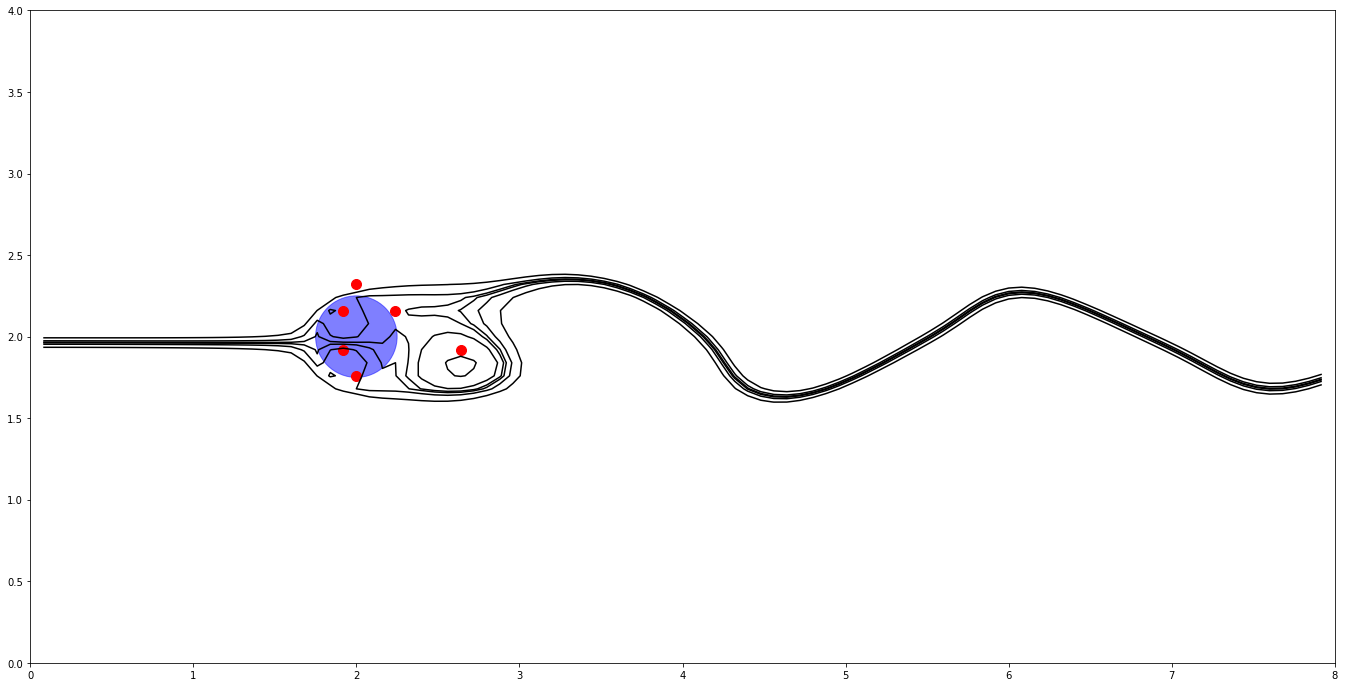

In [26]:
fig = plt.figure(figsize=(26.0, 12.0))
# ax = fig.add_subplot(111, projection='3d')
ax_stream = fig.add_subplot(111)
# surf = ax.plot_surface(X, Y, Z, cmap='bwr', linewidth=0)
# ax_stream.contour(X1, X2, X3, colors = "black", offset = 11, levels=5000)
# cs = ax_stream.contour(X1, X2, X3, colors = "black", levels= np.linspace(5.94, 6.03, num =100))
# cs = ax_stream.contour(X1, X2, X3, colors = "black", levels= np.linspace(2.983, 2.994, num =10))
levelarray = [0] * len(index_i)
for k in range(len(index_i)):
    ik = index_i[k]
    jk = index_j[k]
    levelarray[k] = zdata[ik * (nj - 1) + jk]
levelarray = np.array(levelarray)
levelarray = np.sort(levelarray)
cs = ax_stream.contour(X1, X2, X3, colors = "black", levels=levelarray)
# cs = ax_stream.contour(X1, X2, X3, colors = "black", levels= np.linspace(np.min(levelarray),np.max(levelarray), num =20))
ax_stream.set_xlim(left_stream, right_stream)
ax_stream.set_ylim(under_stream, above_stream)
# cc_stream = plt.Circle((6.0, 6.0), 0.5,fill=True, color="blue", alpha = 0.5)
cc_stream = plt.Circle((2.0, 2.0), 0.25,fill=True, color="blue", alpha = 0.5)
ax_stream.add_artist(cc_stream)
ax_stream.set_aspect("equal")
for k in range(len(index_i)):
    ik = index_i[k]
    jk = index_j[k]
    print((X[jk][ik], Y[jk][ik]))
    ax_stream.scatter(X[jk][ik], Y[jk][ik], s=100, c='red', marker='o')
plt.show()

## 速度ベクトル場

In [27]:
left = 0 
right = 8 
under = 0 
above = 4 
scale = 15.0 

(2.0, 2.32)
(1.92, 2.16)
(2.24, 2.16)
(1.92, 1.92)
(2.64, 1.92)
(2.0, 1.76)


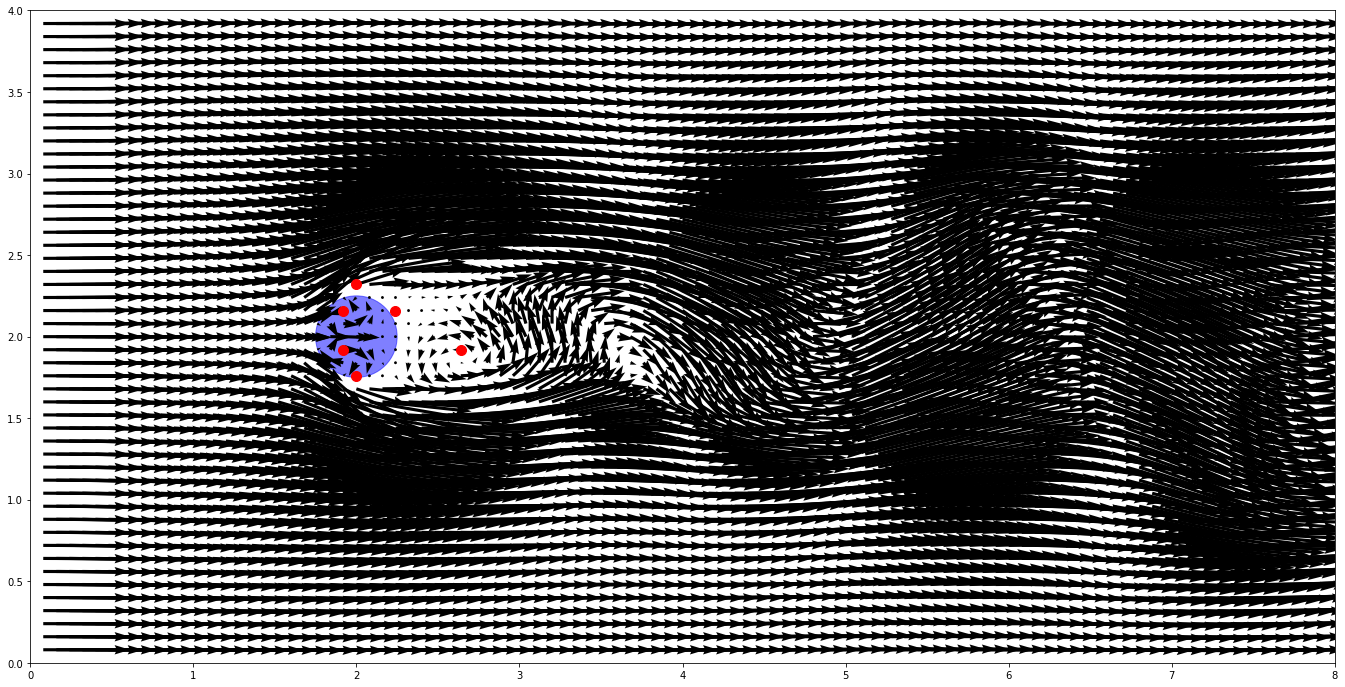

In [28]:
fig_vec, ax_vec = plt.subplots(figsize=(26.0, 12.0))
ax_vec.set_aspect("equal")
ax_vec.set_xlim(left, right)
ax_vec.set_ylim(under, above)
cc = plt.Circle((2.0, 2.0), 0.25,fill=True, color="blue", alpha = 0.5)
ax_vec.add_artist(cc)
ax_vec.quiver(X, Y, U, V, scale=scale)
for k in range(len(index_i)):
    ik = index_i[k]
    jk = index_j[k]
    print((X[jk][ik], Y[jk][ik]))
    ax_vec.scatter(X[jk][ik], Y[jk][ik], s=100, c='red', marker='o')
plt.show()